In [1]:
import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
HEADERS = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=HEADERS)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=HEADERS)

test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(
   lambda value: value.replace(".", "")
)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16281, 15)


In [3]:
train_data.sample(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
5641,40,Private,115161,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,30,United-States,<=50K
27185,28,Self-emp-not-inc,294398,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,Black,Male,0,0,40,United-States,<=50K
9030,77,?,185426,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,15,United-States,<=50K
17607,26,Private,244372,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,52,United-States,>50K
1784,31,Private,19302,Assoc-acdm,12,Never-married,Adm-clerical,Not-in-family,White,Male,2202,0,38,United-States,<=50K
4875,49,Local-gov,337768,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
21056,64,Local-gov,142166,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,99,United-States,<=50K
9678,29,Self-emp-inc,190450,HS-grad,9,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,0,40,Germany,<=50K
27002,30,Private,95299,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Asian-Pac-Islander,Male,0,0,40,Vietnam,>50K
3023,38,Private,53930,10th,6,Never-married,Craft-repair,Not-in-family,Black,Male,0,0,40,?,<=50K


In [4]:
train_data.sample(5)[["age", "education", "marital_status", "hours_per_week", "income_bracket"]]

,age,education,marital_status,hours_per_week,income_bracket
23991,62,Assoc-voc,Divorced,40,<=50K
19530,30,Bachelors,Married-civ-spouse,40,<=50K
19393,38,HS-grad,Never-married,40,<=50K
15020,58,5th-6th,Married-civ-spouse,40,<=50K
254,58,Some-college,Never-married,20,<=50K


In [5]:
train_data.replace(" ?", None, inplace=True)
test_data.replace(" ?", None, inplace=True)

In [6]:
def sort_none_last(xs):
    return sorted(xs, key=lambda x: (x is None, x))

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sort_none_last(list(train_data["workclass"].unique())),
    "education": sort_none_last(list(train_data["education"].unique())),
    "marital_status": sort_none_last(list(train_data["marital_status"].unique())),
    "occupation": sort_none_last(list(train_data["occupation"].unique())),
    "relationship": sort_none_last(list(train_data["relationship"].unique())),
    "race": sort_none_last(list(train_data["race"].unique())),
    "gender": sort_none_last(list(train_data["gender"].unique())),
    "native_country": sort_none_last(list(train_data["native_country"].unique())),
    "income_bracket": sort_none_last(list(train_data["income_bracket"].unique())),
}

In [7]:
for c in CATEGORICAL_FEATURES_WITH_VOCABULARY.keys():
    for dataset in [train_data, test_data]:
        dataset[c] = dataset[c].astype('category')
        dataset[c] = dataset[c].astype('category')

In [8]:
def map_to_index(val, vocab):
    if val is None:
        return None
    return vocab.index(val)

for dataset in (train_data, test_data):
    for feature, vocab in CATEGORICAL_FEATURES_WITH_VOCABULARY.items():
        dataset[feature] = dataset[feature].map(lambda val: map_to_index(val, vocab))

In [9]:
train_data.sample(5)[["age", "education", "marital_status", "hours_per_week", "income_bracket"]]

,age,education,marital_status,hours_per_week,income_bracket
18823,33,5,0,35,0
9469,32,9,2,8,1
12810,47,1,2,40,0
25633,56,14,2,40,1
15983,26,15,2,40,0


In [10]:
train_data.sample(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
4809,33,3,209900,15,10,4,12,3,4,1,0,0,20,38,0
27941,19,3,278115,15,10,4,7,3,4,1,0,0,12,38,0
19344,25,5,72338,11,9,4,11,4,1,0,0,0,40,38,0
2460,38,3,31069,8,11,2,2,0,4,1,4386,0,40,38,1
14688,17,NaN,303317,1,7,4,NaN,3,4,1,0,0,40,38,0
11239,35,5,308874,11,9,4,2,1,2,1,0,0,40,38,0
14023,23,3,376416,9,13,4,0,1,4,1,0,0,40,38,0
5695,63,3,339473,15,10,0,11,1,4,0,0,0,60,38,0
13763,51,5,136322,11,9,2,4,0,4,1,0,1579,40,38,0
27165,45,0,179638,12,14,0,3,1,4,1,0,0,40,38,1


In [11]:
test_data.sample(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
13369,42,4,203233.0,14,15.0,2,9,0,4,1,99999.0,0.0,99.0,38,1
16229,35,1,297322.0,15,10.0,2,13,0,2,1,0.0,0.0,40.0,38,1
16035,69,5,215926.0,5,4.0,2,7,0,4,1,0.0,0.0,35.0,38,0
4907,32,5,178109.0,0,6.0,2,3,0,4,1,0.0,0.0,55.0,38,0
7357,46,3,235334.0,12,14.0,2,3,0,2,1,99999.0,0.0,60.0,38,1
12917,49,3,117310.0,7,12.0,2,0,3,4,0,0.0,0.0,38.0,38,0
15840,72,NaN,94268.0,11,9.0,2,NaN,0,4,1,0.0,0.0,8.0,38,0
1,25,3,226802.0,1,7.0,4,6,3,2,1,0.0,0.0,40.0,38,0
6024,52,1,182856.0,12,14.0,4,9,1,4,1,10520.0,0.0,45.0,38,1
11736,51,3,203435.0,11,9.0,0,11,1,4,0,0.0,0.0,40.0,38,0


In [12]:
train_data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
gender               0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income_bracket       0
dtype: int64

In [13]:
train_data[train_data.duplicated() == True]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
4881,25,3,308144,9,13,4,2,1,4,1,0,0,40,25,0
5104,90,3,52386,15,10,4,7,1,1,1,0,0,35,38,0
9171,21,3,250051,15,10,4,9,3,4,0,0,0,10,38,0
11631,20,3,107658,15,10,4,12,1,4,0,0,0,10,38,0
13084,25,3,195994,3,2,4,8,1,4,0,0,0,40,12,0
15059,21,3,243368,13,1,4,4,1,4,1,0,0,50,25,0
17040,46,3,173243,11,9,2,2,0,4,1,0,0,40,38,0
18555,30,3,144593,11,9,4,7,1,2,1,0,0,40,NaN,0
18698,19,3,97261,11,9,4,4,1,4,1,0,0,40,38,0
21318,19,3,138153,15,10,4,0,3,4,0,0,0,10,38,0


In [14]:
train_data.drop_duplicates(inplace=True)

In [15]:
train_data.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32537.000000,3.253700e+04,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1.897808e+05,10.081815,1078.443741,87.368227,40.440329
std,13.637984,1.055565e+05,2.571633,7387.957424,403.101833,12.346889
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369930e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Text(0.5, 1.0, 'Correlation Heatmap')

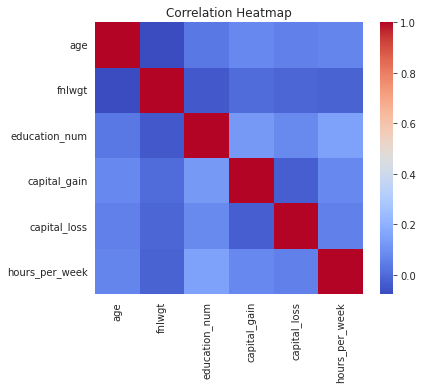

In [16]:
plt.figure(figsize=(6,5))
sns.heatmap(train_data.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')

In [17]:
counts = np.bincount(train_data["income_bracket"])
class_weight = {
    0: counts[0] / train_data.shape[0],
    1: counts[1] / train_data.shape[0]
}
scale_pos_weight = class_weight[0]/class_weight[1]
scale_pos_weight

3.1506569715524937

In [18]:
X_train = train_data.drop(columns=["income_bracket"], axis=1)
y_train = train_data["income_bracket"]
X_test = test_data.drop(columns=["income_bracket"], axis=1)
y_test = test_data["income_bracket"]

In [19]:
start = time.time()
model = lgb.LGBMClassifier(force_row_wise=True, boosting_type="gbdt", scale_pos_weight=scale_pos_weight, learning_rate=0.162, max_bin=320, n_estimators=360)
model = model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 7839, number of negative: 24698
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 32537, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240926 -> initscore=-1.147611
[LightGBM] [Info] Start training from score -1.147611


In [20]:
y_pred = model.predict(X_test.values)
print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
end = time.time()
print(f"Training time: {end - start}s")

F1 score: 0.7104600595101854
Accuracy: 0.8446041397948529
Training time: 1.0591073036193848s
